Importamos las librerias a utilizar

In [1]:
import pandas as pd
import os
import glob

Damos la ruta de los archivos

In [3]:
path = 'Etiquetas'

Cargamos nuestros archivos

In [4]:
files = os.path.join("Etiquetas", "*.csv")
files = glob.glob(files)
df = pd.concat(map(pd.read_csv, files), ignore_index=False)
df = df[["etiqueta", "x1", "y1", "x2", "y2", "imagen", "w", "h"]]

In [5]:
df = df.loc[(df['etiqueta'] == 'borde_izquierdo') | (df['etiqueta'] == 'borde_derecho')]

In [6]:
df.head()

,etiqueta,x1,y1,x2,y2,imagen,w,h
0,borde_izquierdo,49,409,372,343,re_2021_05_30_150852_001.png,960.0,540
4,borde_izquierdo,46,413,328,349,re_2021_05_30_150852_002.png,960.0,540
9,borde_izquierdo,6,380,340,343,re_2021_05_30_150852_003.png,960.0,540
13,borde_derecho,641,354,956,395,re_2021_05_30_150852_003.png,960.0,540
14,borde_izquierdo,13,388,348,349,re_2021_05_30_150852_004.png,960.0,540


Creamos la funcion para extraer los valores de la imagen

In [7]:
# Funcion para extraer la subcadena i-esima de la tupla
def parametroImagen(subCadena):
    """ 
    Documentar lo siguiente
    Input:
    -------    
    Output:    
    """
    Pc = 1
    c1, c2, c3, c4 = 0, 0, 0, 0
    if subCadena[0] == 'linea_carril': 
        c1 = 1
    elif subCadena[0] == 'linea_emergencia': 
        c2 = 1  
    elif subCadena[0] == 'borde_izquierdo': 
        c3 = 1
    elif subCadena[0] == 'borde_derecho': 
        c4 = 1
    x1 = subCadena[1]
    y1 = subCadena[2]
    x2 = subCadena[3]
    y2 = subCadena[4]
    w =  subCadena[6]
    h = subCadena[7]
    return [Pc, c1, c2, c3, c4, x1, y1, x2, y2]

Ahora vamos a juntar en un solo arreglo los datos que correspondan a la misma imagen

In [8]:
# Creamos una lista con los nombres de las imagenes (sin repetir)
nombres  = df['imagen'].unique()
repeticionesPorImagen = []
datosImagenes = []

for nombre in nombres:
    repeticionesPorImagen.append(list(df['imagen']).count(nombre))

# Aqui vamos a crear un arreglo con los datos de una misma imagen
# para recorrernos en todas las imagenes usaremos slices del tipo [n, n + x].
n = 0
pivote = 0
for pivoteTemp in repeticionesPorImagen:
    pivote = pivoteTemp + n
    datosImagenes.append(df[n:pivote].values)
    n += pivoteTemp

Vectores generales

In [9]:
VectorGeneral = []
VectorTemp = []
flagEmergencia = 0
lineasTotales = 7
dic_nombre_marcas = {}

# Cargamos las dimensiones de las imagenes de cualquier arreglo
w = datosImagenes[0][0][-2]
h = datosImagenes[0][0][-1]

# Iteramos sobre el numero de datos de imagenes que tenemos
# en este caso son 972
for i in range(len(datosImagenes)):
    # Aqui vamos a iterar sobre los arreglos de datos de cada imagen
    for j in range(len(datosImagenes[i])):   
        # Extraemos la fila de parametros de la imagen dada una etiqueta
        datosImagenVec = parametroImagen(datosImagenes[i][j])
        VectorTemp.append(datosImagenVec)
        # Banderas de BordeIzquierdo, BordeDerecho y LineaDeEmergencia
        flagEmergencia = datosImagenVec[2]
        flagBordeIzquierdo = datosImagenVec[3]
        flagBordeDerecho = datosImagenVec[4]     
    while len(VectorTemp) < lineasTotales:
        # Aqui verificamos si ya tenemos un registro de linea de emergencia
        if flagEmergencia == 0:
            VectorTemp.append([0, 1, 0, 0, 0, 0, 0, 0, 0])
            flagBordeDerecho = 1
        # Aqui verificamos si ya tenemos un registro de borde derecho
        elif flagBordeDerecho == 0:
            VectorTemp.append([0, 0, 0, 0, 1, 0, 0, 0, 0])
            flagBordeDerecho = 1
        # Aqui verificamos si ya tenemos un registro de borde izquierdo
        elif flagBordeIzquierdo == 0:
            VectorTemp.append([0, 0, 0, 1, 0, 0, 0, 0, 0])
            flagBordeIzquierdo = 1
        # Por ultimo agregamos las lineas de carril en las posiciones sobrantes
        else:
            VectorTemp.append([0, 0, 1, 0, 0, 0, 0, 0, 0])
            flagEmergencia = 1 # Dado que ya habremos agregado la linea de Emergancia           
    nombreImagen = datosImagenes[i][j][5]
    dic_nombre_marcas[nombreImagen] = VectorTemp.copy()
    nombreImagen = [datosImagenes[i][j][5]]
    VectorTemp.append(nombreImagen) # Le pasamos el nombre de la imagen
    VectorGeneral.append(VectorTemp) # Cargamos la fila de valores al VectorGeneral
    VectorTemp = [] # Reseteamos nuestro vector temporal
    
    
# Aplanado del vector
VectorGeneralAplanado = []
flat_list = []

for item in VectorGeneral:
    for l in item:
        flat_list += l
    flat_list.extend([w, h])
    VectorGeneralAplanado.append(flat_list)
    flat_list = []

De modo que tenemos el siguiente vector para la imagen No.941

Ahora vemos el vector aplanado

In [10]:
print(VectorGeneralAplanado[911])

[1, 0, 0, 0, 1, 791, 368, 572, 338, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 're_2021_06_02_195657_045.png', 960.0, 540]


In [11]:
pd.DataFrame(VectorGeneralAplanado).to_csv('sample.csv')

In [12]:
df.to_csv('out.zip', index=False)  

In [13]:
## Entreno 777, testeo 194

In [14]:
pd.DataFrame(VectorGeneralAplanado[:777]).to_csv('set_entreno.csv')
pd.DataFrame(VectorGeneralAplanado[777:]).to_csv('set_prueba.csv')

## TODO:
-  ~~Dejar solo un parametro $w$ y $h$ para el arreglo __Prueba[i]__~~
- ~~Determinar como calcular $P_c$~~
- ~~Asegurarse de que cada $i$-esimo subtable de la tabla general contenga 65 elementos~~
- ~~Refactorizar y simplificar codigo existente~~
- ~Escribir $\LaTeX$~
- Documentar

---

## Dibujado de lineas en imagenes.

El objetivo de esta seccion es dibujar las lineas en las imagenes dado su vector $y_n$ obtenido en la sección anterior.

Vamos a definir un codigo de colores para la clafisicación de cada una de las lineas.
- Azul: Carril
- Verde: Borde derecho, Borde Izquierdo
- Amarillo: Linea de emergencia

In [15]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import random


Bad key "legend.title_fontsize" on line 22 in
C:\Users\masan\.matplotlib\stylelib\notebook.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [16]:
images_path = 'imagenes/'
posicion_nombre = 63
imagenes = VectorGeneral

In [19]:
img1

1958


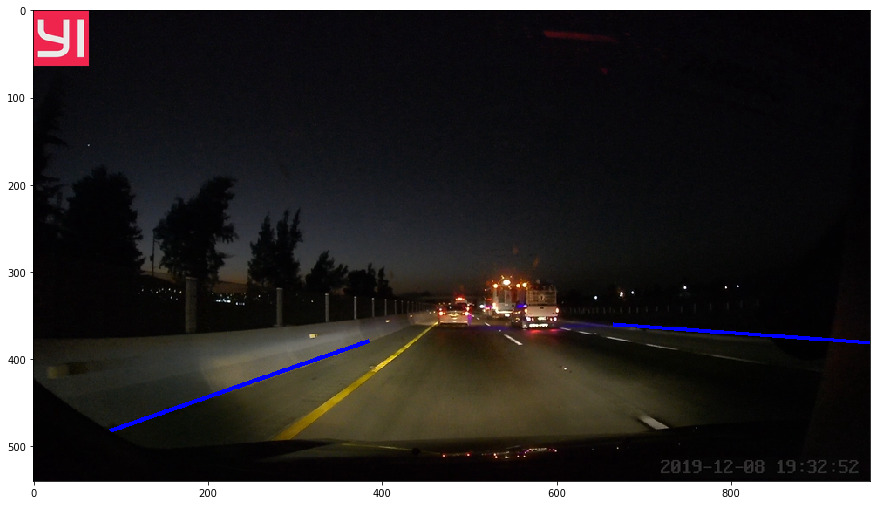

In [20]:
# imagen general

imagen_aleatoria = random.randint(0, len(imagenes))
img = Image.open(images_path + VectorGeneralAplanado[imagen_aleatoria][posicion_nombre])
print(imagen_aleatoria)
# imagen sobre la que vamos a dibujar
img1 = ImageDraw.Draw(img)

# Intento 2 - Esperemos que el bueno

for linea in imagenes[imagen_aleatoria][:7]:
    shape = [(linea[5], linea[6]) , (linea[7] , linea[8])]

    # color de la linea
    if linea[1] == 1:
        color = 'green'
    elif linea[2] == 1:
        color = 'red'
    elif linea[3] == 1:
        color = 'blue'
    elif linea[4]  == 1:
        color = 'blue'
    else:
        color = 'red'

    # creamos la linea
    img1.line(shape, fill = color, width = 5)


# despliegue de imagen
fig = plt.figure(figsize=(15,16))
plt.imshow(img)

---

Ahora vamos a preparar los datos para entrenar nuestra red.

In [17]:
import torch
from torch.utils.data import DataLoader
import torchvision
import PIL

In [18]:
n = 100
img_name = imagenes[n][-1][0]
img_puntos = imagenes[n][:-1]

print(f"Name: {img_name}")
print(f"Primeras 3 lineas: {img_puntos[:3]}")

Name: 2019_10_26_121247_025_resized.png
Primeras 3 lineas: [[1, 0, 0, 1, 0, 2, 398, 301, 371], [1, 0, 0, 0, 1, 960, 403, 606, 377], [1, 1, 0, 0, 0, 4, 421, 300, 380]]


In [19]:
import torchvision.transforms as transforms

nombre_imagen = imagenes[0][-1][0]
imagen_individual = PIL.Image.open(f"imagenes/{nombre_imagen}")
transform_to_tensor = transforms.Compose([transforms.ToTensor()])
imagen_tensor = transform_to_tensor(imagen_individual)

Vamos a crear una lista que contenga a las imagenes en forma de arreglo.

In [20]:
# imagenes = {nombre_imagen: array_imagen_tensor, .... ,}

In [21]:
import torchvision.transforms as transforms

dic_nombre_imagen = {}
transform_to_tensor = transforms.Compose([transforms.ToTensor()])

for i in range(len(imagenes)):
    nombre_imagen = imagenes[i][-1][0]
    imagen_individual = PIL.Image.open(f"imagenes/{nombre_imagen}")
    imagen_tensor = transform_to_tensor(imagen_individual)
    dic_nombre_imagen[nombre_imagen] = imagen_tensor

Como el script anterior tarda algo, vamos a guardarlo en un archivo .csv, con el fin de no realizar la operación anterior
cada vez que entremos al script.

Ya que tenemos guardados los datos en un csv vamos a ver como sería la carga de datos al dic.

# PENDIENTE.

In [22]:
nombres_imagenes = []
for i in range(len(imagenes)):
    nombre = imagenes[i][-1][0]
    nombres_imagenes.append(nombre)

In [23]:
dic_nombre_imagen['2019_10_26_121247_025_resized.png'].size()

torch.Size([3, 540, 960])

In [24]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

In [25]:
def ToTensor(img_name, img_tensor, img_marcas):
    imagen, marcas = img_tensor[img_name], img_marcas[img_name]
    marcas = torch.from_numpy(np.array(marcas))
    return {'image': imagen,
           'marcas': marcas}

In [26]:
ToTensor('2019_10_26_121247_025_resized.png', dic_nombre_imagen, dic_nombre_marcas)['image'].size()

torch.Size([3, 540, 960])

In [27]:
ToTensor('2019_10_26_121247_025_resized.png', dic_nombre_imagen, dic_nombre_marcas)['marcas'].size()

torch.Size([7, 9])

Prueba de datos

In [28]:
transformed_dataset = []
for i in range(len(imagenes)):
    nombre = nombres_imagenes[i]
    imagen = ToTensor(nombre, dic_nombre_imagen, dic_nombre_marcas)['image']
    marcas = ToTensor(nombre, dic_nombre_imagen, dic_nombre_marcas)['marcas']                                                                    
    transformed_dataset.append({'image': imagen, 
                                'marcas': marcas})

In [29]:
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].shape, sample['marcas'].shape)

0 torch.Size([3, 540, 960]) torch.Size([7, 9])
1 torch.Size([3, 540, 960]) torch.Size([7, 9])
2 torch.Size([3, 540, 960]) torch.Size([7, 9])
3 torch.Size([3, 540, 960]) torch.Size([7, 9])


---

Arquitectura de la red.

La arquitectura de la red la vamos a encontrar en modelo.py

In [30]:
transformed_dataset[0]

{'image': tensor([[[0.9686, 0.9490, 0.9490,  ..., 0.4863, 0.4863, 0.4863],
          [0.9529, 0.9294, 0.9294,  ..., 0.4863, 0.4863, 0.4863],
          [0.9569, 0.9333, 0.9333,  ..., 0.4863, 0.4863, 0.4863],
          ...,
          [0.2314, 0.2353, 0.2314,  ..., 0.0235, 0.0235, 0.0235],
          [0.2314, 0.2275, 0.2275,  ..., 0.0235, 0.0235, 0.0235],
          [0.2275, 0.2275, 0.2275,  ..., 0.0235, 0.0235, 0.0235]],
 
         [[0.1882, 0.1647, 0.1647,  ..., 0.5020, 0.5020, 0.5020],
          [0.1686, 0.1451, 0.1451,  ..., 0.5020, 0.5020, 0.5020],
          [0.1725, 0.1490, 0.1490,  ..., 0.5020, 0.5020, 0.5020],
          ...,
          [0.2275, 0.2314, 0.2275,  ..., 0.0235, 0.0235, 0.0235],
          [0.2275, 0.2235, 0.2235,  ..., 0.0235, 0.0235, 0.0235],
          [0.2235, 0.2235, 0.2235,  ..., 0.0235, 0.0235, 0.0235]],
 
         [[0.3529, 0.3294, 0.3294,  ..., 0.5490, 0.5490, 0.5490],
          [0.3333, 0.3098, 0.3098,  ..., 0.5490, 0.5490, 0.5490],
          [0.3373, 0.3137, 0.31

In [104]:
from modelo import Net

dropout_prob = 0.5
net = Net(dropout_prob)
net.to(device)
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=5000, bias=True)
  (drop5): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=5000, out_features=1024, bias=True)
  (drop6): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=1024, out_features=45, bias=True)
)


## Batching

In [131]:
batch_size = 5
train_loader = DataLoader(transformed_dataset, batch_size, shuffle=True)

In [132]:
train_loader

In [133]:
from torch.autograd import Variable

In [136]:
def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(train_loader):
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['marcas']

        # convert images to FloatTensors
        #images = images.type(torch.FloatTensor)
        
        # wrap them in a torch Variable
        images = Variable(images)    
        images = images.to(device)
        
        # forward pass to get net output
        output_pts = net(images)
        images = images.to(device)
        output_pts = output_pts.to(Device)
        #print('net output')
        #print(output_pts.shape)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 45, -1)
        #print('net output reshaped')
        #print(output_pts.shape)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

In [137]:
test_images, test_outputs, gt_pts = net_sample_output()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (5x111360 and 9216x5000)